In [1]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from mutation import MyMutation
from crossover import TraceCrossover
from encoder import Encoder
from sampling import MySampling
from callback import UpdatePopulationCallback, UpdatePopCallback
import numpy as np
from tools import Tools
from survival import MySurvival
from Declare4Py.ProcessModels.DeclareModel import DeclareModel
from Declare4Py.D4PyEventLog import D4PyEventLog
import warnings
import random
from Declare4Py.ProcessMiningTasks.ConformanceChecking.MPDeclareResultsBrowser import MPDeclareResultsBrowser
from Declare4Py.ProcessMiningTasks.ConformanceChecking.MPDeclareAnalyzer import MPDeclareAnalyzer
import pandas as pd
import logging
from terminator import MyTermination
from problem import Problem_single_ElementWise, MyProblem_Problem, MyProblem_Problem2, Problem_multi_ElementWise, Problem_single_ElementWise_noConstraints
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.termination.default import DefaultSingleObjectiveTermination
import testSetup
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import SBX
from mutation import IntegerPolynomialMutation




logging.getLogger('matplotlib').setLevel(logging.WARNING)
warnings.filterwarnings("ignore", ".*feasible.*")


# declare = DeclareModel().parse_from_file("../declare_models/model1.decl")
# model_constraints = declare.get_decl_model_constraints()
# activities_name = declare.get_model_activities()
#
# encoder = Encoder(activities_name)
#
# variable_boundaries = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
# timestamps = Tools.generate_random_timestamps(len(activities_name))
# case_concept_name = ['1'] * len(activities_name)
#
# data = {
#     'case:concept:name': case_concept_name,
#     'concept:name': activities_name,
#     'timestamp': timestamps,
# }
#
# dataframe = pd.DataFrame(data)
#
#
# dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'])




# create random pop
n_traces = 100
trace_length = 50
variable_boundaries = [1] * trace_length

trace = [
    "Return ER", "LacticAcid", "Return ER", "IV Liquid", "ER Triage",
    "ER Sepsis Triage", "IV Antibiotics", "LacticAcid", "Admission NC",
    "Release B", "IV Liquid", "LacticAcid", "ER Registration",
    "ER Sepsis Triage", "Admission NC", "Admission IC", "LacticAcid",
    "ER Sepsis Triage", "LacticAcid", "Release A"
]

declare = DeclareModel().parse_from_file("../declare_models/model1.decl")

activities_name = declare.get_model_activities()

timestamps = Tools.generate_random_timestamps(trace_length)

data = {
    'case:concept:name': ['1'] * trace_length,
    'concept:name': ['1'] * trace_length,
    'timestamp': pd.to_datetime(timestamps),
}

dataframe = pd.DataFrame(data)

event_log = D4PyEventLog()
event_log.log = dataframe
event_log.timestamp_key = "timestamp"
event_log.activity_key = "concept:name"

event_log.to_eventlog()

model_constraints = declare.get_decl_model_constraints()

encoder = Encoder(activities_name)

print(activities_name)


['Release B', 'ER Triage', 'ER Registration', 'ER Sepsis Triage', 'Leucocytes', 'CRP', 'LacticAcid', 'IV Antibiotics', 'Admission NC', 'IV Liquid', 'Release A', 'Return ER', 'Admission IC']


In [2]:




from pymoo.termination.default import DefaultMultiObjectiveTermination

# initial_population = [[random.choice(activities_name) for _ in range(trace_length)] for _ in range(n_traces)]

# Load CSV file with correct column names
df = pd.read_csv("../declare_models/model1_initial_pop.csv", usecols=['Case ID', 'Activity'])

# Group activities by case, filter cases with at least 50 activities, and select the first 10 cases
initial_population = [
    activities[:50] for activities in
    (df.groupby('Case ID')['Activity'].apply(list).values) if len(activities) >= 50
][:10]




print(initial_population)
initial_encoded_pop = [encoder.encode(trace) for trace in initial_population]

# features_range = Tools.calculate_feature_range(initial_encoded_pop, variable_boundaries)
# lower_bounds = [x[0] for x in features_range]
# upper_bounds = [x[1] for x in features_range]
lower_bounds = 0
upper_bounds = len(activities_name) - 1


# mutation = MyMutation(feature_range=features_range)
# mutation = PolynomialMutation(prob=0.1, eta=20)
mutation = IntegerPolynomialMutation(prob=0.4,eta=20) # low eta (5–10) → More exploration - high eta (15–50) → More exploitation
# crossover = TraceCrossover(variable_boundaries=variable_boundaries)
crossover = SBX(prob=0.9, eta=15)
sampling = MySampling(initial_population=initial_encoded_pop)
pop_size = 3000
survival = MySurvival(n_children_survive=50)

termination_multi = DefaultMultiObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=0.0025,
    period=30,
    n_max_gen=1000,
    n_max_evals=100000
)

termination_single = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=20,
    n_max_gen=1000,
    n_max_evals=100000
)


termination = MyTermination(n_required=pop_size)
# termination = get_termination("n_gen", 10)
# termination1 = termination
# termination2 = termination
print('\n----------------------------------------------\n')
print(len(trace))
print('\n----------------------------------------------\n')
print(trace_length)

for x in initial_population:
    dataframe['concept:name'] = pd.DataFrame(x)
    event_log.log = dataframe
    event_log.to_eventlog()

    basic_checker = MPDeclareAnalyzer(log=event_log, declare_model=declare, consider_vacuity=False)
    conf_check_res: MPDeclareResultsBrowser = basic_checker.run()
    metric_state = conf_check_res.get_metric(trace_id=0, metric="state")
    metric_num_violation = conf_check_res.get_metric(trace_id=0, metric="num_violations")

    print("Solution Decoded:")
    print(metric_num_violation)
    print("-------------------------------------------")



[['LacticAcid', 'CRP', 'ER Sepsis Triage', 'IV Antibiotics', 'IV Liquid', 'Leucocytes', 'Release A', 'Leucocytes', 'ER Registration', 'Admission NC', 'Release B', 'ER Triage', 'Admission NC', 'Release B', 'Release A', 'IV Liquid', 'Admission IC', 'IV Liquid', 'Admission NC', 'Release B', 'Admission IC', 'LacticAcid', 'Admission IC', 'ER Registration', 'Leucocytes', 'LacticAcid', 'LacticAcid', 'LacticAcid', 'Leucocytes', 'Admission IC', 'Admission IC', 'Leucocytes', 'Admission IC', 'CRP', 'ER Registration', 'Admission IC', 'CRP', 'LacticAcid', 'LacticAcid', 'ER Registration', 'LacticAcid', 'Leucocytes', 'Release A', 'CRP', 'Admission NC', 'Release B', 'CRP', 'Release A', 'CRP', 'Admission IC'], ['Release A', 'ER Registration', 'ER Sepsis Triage', 'IV Antibiotics', 'ER Registration', 'ER Registration', 'Admission NC', 'Release B', 'Admission NC', 'Release B', 'IV Liquid', 'Admission IC', 'CRP', 'CRP', 'Leucocytes', 'Admission NC', 'Release B', 'ER Registration', 'ER Registration', 'ER Re

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       10 |  0.000000E+00 |  0.000000E+00 | -4.074000E+01 | -4.210000E+01
     2 |     3010 |  0.000000E+00 |  4.1400000000 | -4.126400E+01 | -4.230000E+01
     3 |     6010 |  0.000000E+00 |  3.4076666667 | -4.128889E+01 | -4.250000E+01
     4 |     9010 |  0.000000E+00 |  2.8266666667 | -4.132661E+01 | -4.250000E+01
     5 |    12010 |  0.000000E+00 |  2.4053333333 | -4.135543E+01 | -4.250000E+01
     6 |    15010 |  0.000000E+00 |  1.8460000000 | -4.141143E+01 | -4.260000E+01
     7 |    18010 |  0.000000E+00 |  1.3390000000 | -4.150467E+01 | -4.270000E+01
     8 |    21010 |  0.000000E+00 |  0.6996666667 | -4.160548E+01 | -4.340000E+01
     9 |    24010 |  0.000000E+00 |  0.1386666667 | -4.173893E+01 | -4.360000E+01
    10 |    27010 |  0.000000E+00 |  0.000000E+00 | -4.216767E+01 | -4.390000E+01
10
[0.0, 4.14, 3.4076666666666666, 2.8266666666666667, 2.4053333333333335, 1.846, 1.339, 0.6996666

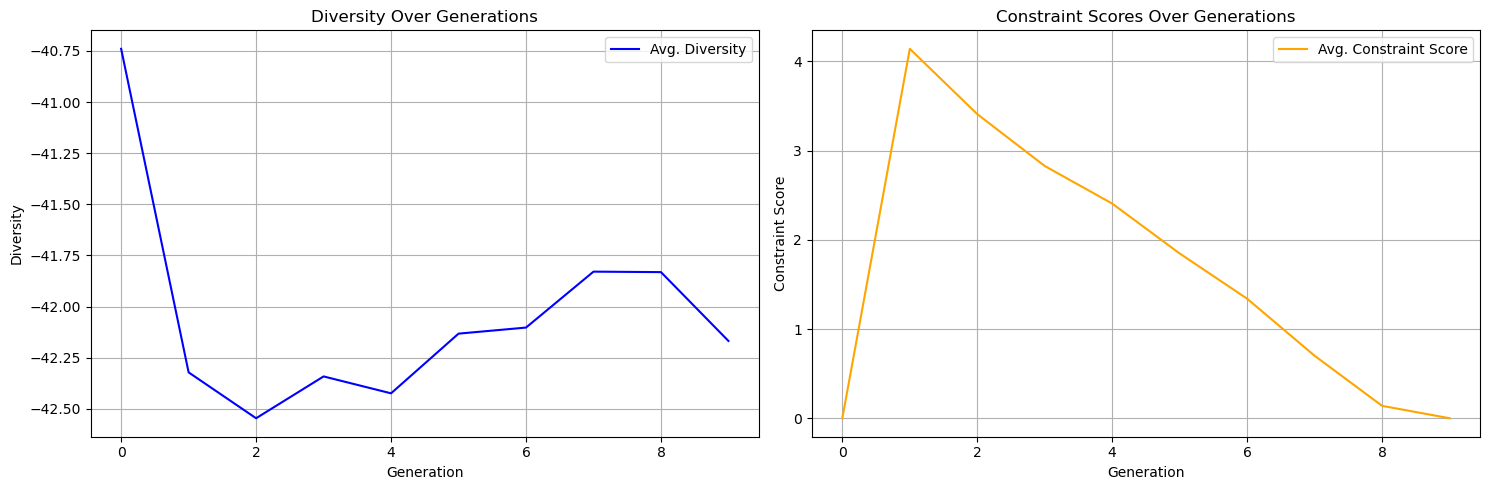

Feasible Trace 1: [5, 4, 11, 2, 8, 0, 6, 11, 1, 10, 11, 5, 10, 11, 3, 7, 10, 11, 5, 6, 10, 8, 0, 10, 5, 5, 5, 4, 12, 4, 2, 2, 4, 10, 4, 5, 10, 9, 9, 5, 2, 8, 0, 12, 9, 8, 0, 8, 0, 11]
Solution Decoded: ['CRP', 'Leucocytes', 'Return ER', 'ER Registration', 'Admission NC', 'Release B', 'LacticAcid', 'Return ER', 'ER Triage', 'Release A', 'Return ER', 'CRP', 'Release A', 'Return ER', 'ER Sepsis Triage', 'IV Antibiotics', 'Release A', 'Return ER', 'CRP', 'LacticAcid', 'Release A', 'Admission NC', 'Release B', 'Release A', 'CRP', 'CRP', 'CRP', 'Leucocytes', 'Admission IC', 'Leucocytes', 'ER Registration', 'ER Registration', 'Leucocytes', 'Release A', 'Leucocytes', 'CRP', 'Release A', 'IV Liquid', 'IV Liquid', 'CRP', 'ER Registration', 'Admission NC', 'Release B', 'Admission IC', 'IV Liquid', 'Admission NC', 'Release B', 'Admission NC', 'Release B', 'Return ER']
[None, 0, None, None, None, None, None, None, None, None, 0, None, None, None, 0, 0, None]
----------------------------------------

In [3]:
from testSetup import Setup


# (encoder, declare, event_log, dataframe, activities_name) = Setup.initialize_shared_components("../declare_models/model1.decl", trace_length)


multi_problem = Problem_multi_ElementWise(
    trace_length=trace_length,
    encoder=encoder,
    d4py=declare,
    initial_population=initial_encoded_pop,
    xl=lower_bounds,xu=upper_bounds,
    event_log=event_log,
    dataframe=dataframe
)

single_problem = Problem_single_ElementWise(
    trace_length=trace_length,
    encoder=encoder,
    d4py=declare,
    initial_population=initial_encoded_pop,
    xl=lower_bounds,xu=upper_bounds,
    event_log=event_log,
    dataframe=dataframe
)


multi_algorithm = NSGA2(
    problem=multi_problem,
    pop_size=pop_size,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    callback=UpdatePopulationCallback(problem=multi_problem),
    eliminate_duplicates=False,
)

single_algorithm = GA(
    problem=single_problem,
    pop_size=pop_size,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    callback=UpdatePopulationCallback(problem=single_problem),
    eliminate_duplicates=False,
)


result = minimize(single_problem, single_algorithm, termination=termination, seed=1, verbose=True)
data = result.algorithm.callback.get_data()
diversity_scores = data.get("diversity_history", None)
constraint_scores = data.get("constraint_history", None)
n_violations_scores = data.get("n_violations_history", None)
n_generations = data.get("generations", None)
print(n_generations)
print(constraint_scores)


Setup.plot_progress(diversity_scores=diversity_scores, constraint_scores=constraint_scores, n_violations_scores=n_violations_scores, n_generations=n_generations)

G = np.array([individual.G for individual in result.pop])
traces = [individual.X.tolist() for individual in result.pop]

# Print the feasible traces
for i, (trace, g) in enumerate(zip(traces, G)):
    if g == 0:
        decoded_trace =  encoder.decode(trace)

        dataframe['concept:name'] = pd.DataFrame(decoded_trace)
        event_log.log = dataframe
        event_log.to_eventlog()

        basic_checker = MPDeclareAnalyzer(log=event_log, declare_model=declare, consider_vacuity=False)
        conf_check_res: MPDeclareResultsBrowser = basic_checker.run()
        print(f"Feasible Trace {i + 1}: {trace}")

        print("Solution Decoded:", encoder.decode(trace))
        print(conf_check_res.get_metric(trace_id=0, metric="num_violations"))
        print("-------------------------------------------")


In [ ]:
problem = Problem_single_ElementWise_noConstraints(
    trace_length=trace_length,
    encoder=encoder,
    d4py=declare,
    initial_population=initial_encoded_pop,
    xl=lower_bounds,xu=upper_bounds,
    event_log=event_log,
    dataframe=dataframe
)

callback = UpdatePopCallback(problem=problem)

algorithm = GA(
    problem=problem,
    pop_size=pop_size,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    callback=callback,
    eliminate_duplicates=False,
)


result = minimize(problem, algorithm, termination=termination, seed=1, verbose=True)

traces = [individual.X.tolist() for individual in result.pop]


print("Best Solution Encoded:", result.X)
# print("Best Solution Decoded:", [encoder.decode(solution) for solution in result.X])
print("Objective Values:", result.F)


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -4.074000E+01 | -4.210000E+01
     2 |     3010 | -4.232533E+01 | -4.500000E+01
     3 |     6010 | -4.368607E+01 | -4.590000E+01
     4 |     9010 | -4.463123E+01 | -4.670000E+01
     5 |    12010 | -4.539723E+01 | -4.700000E+01
     6 |    15010 | -4.599573E+01 | -4.780000E+01
     7 |    18010 | -4.647553E+01 | -4.790000E+01
     8 |    21010 | -4.687963E+01 | -4.830000E+01
     9 |    24010 | -4.720540E+01 | -4.850000E+01
    10 |    27010 | -4.747383E+01 | -4.850000E+01
    11 |    30010 | -4.770767E+01 | -4.900000E+01
    12 |    33010 | -4.790280E+01 | -4.900000E+01
    13 |    36010 | -4.806403E+01 | -4.920000E+01
    14 |    39010 | -4.820803E+01 | -4.920000E+01
    15 |    42010 | -4.834043E+01 | -4.920000E+01
    16 |    45010 | -4.845780E+01 | -4.920000E+01
    17 |    48010 | -4.856257E+01 | -4.930000E+01
    18 |    51010 | -4.865320E+01 | -4.930000E+01
    19 |    54010 | -4.873520E+01 | -4.960000E+01


In [17]:



problem = Problem_single_ElementWise(
    trace_length=trace_length,
    encoder=encoder,
    d4py=declare,
    initial_population=initial_encoded_pop,
    xl=lower_bounds,xu=upper_bounds,
    event_log=event_log,
    dataframe=dataframe
)

callback = UpdatePopulationCallback(problem=problem, plot=0)

algorithm = GA(
    problem=problem,
    pop_size=pop_size,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    callback=callback,
    termination=termination,
    eliminate_duplicates=False,
)


result = minimize(problem, algorithm, termination=termination2, seed=1, verbose=True)

G = np.array([individual.G for individual in result.pop])
traces = [individual.X.tolist() for individual in result.pop]

# Print the feasible traces
for i, (trace, g) in enumerate(zip(traces, G)):
    if g == 0:
        print(f"Feasible Trace {i + 1}: {trace}")

print("Best Solution Encoded:", result.X)
# print("Best Solution Decoded:", [encoder.decode(solution) for solution in result.X])
print("Objective Values:", result.F)
print("Constraint Values:", result.G)


TypeError: UpdatePopulationCallback.__init__() got an unexpected keyword argument 'plot'

only few millisecond faster than the 2 obj algorithm

In [8]:



problem = MyProblem_Problem(
    trace_length=trace_length,
    encoder=encoder,
    d4py=declare,
    initial_population=initial_encoded_pop,
    xl=lower_bounds,xu=upper_bounds,
    event_log=event_log,
    dataframe=dataframe
)

callback = UpdatePopulationCallback(problem=problem, plot=0)


algorithm = NSGA2(
    problem=problem,
    pop_size=pop_size,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    callback=callback,
    termination=termination,
    eliminate_duplicates=False,
)

result = minimize(problem, algorithm, termination=termination1, seed=1, verbose=True)


print("Best Solution Encoded:", result.X)
print("Best Solution Decoded:", [encoder.decode(solution) for solution in result.X])
print("Objective Values:", result.F)
print("Constraint Values:", result.G)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       10 |      1 |  0.3333333333 |  0.7666666667 |             - |             -
     2 |     2010 |      1 |  0.000000E+00 |  0.6755833333 |             - |             -
     3 |     4010 |      1 |  0.000000E+00 |  0.5208333333 |  0.4000000000 |         ideal
     4 |     6010 |      1 |  0.000000E+00 |  0.4137500000 |  0.000000E+00 |             f
     5 |     8010 |      2 |  0.000000E+00 |  0.3443333333 |  0.000000E+00 |             f
     6 |    10010 |      1 |  0.000000E+00 |  0.2790000000 |  0.2000000000 |         ideal
     7 |    12010 |      5 |  0.000000E+00 |  0.2414166667 |  0.1000000000 |         ideal
     8 |    14010 |      1 |  0.000000E+00 |  0.1887500000 |  0.4000000000 |         ideal
     9 |    16010 |      1 |  0.000000E+00 |  0.1365000000 |  0.1000000000 |         ideal
    10 |    18010 |      1 |  0.000000E+00 |  0.1208333333 |  0.000000E+00 |             f

Seems a little slower than with ElementalWise problem object

In [9]:



problem = MyProblem_Problem2(
    trace_length=trace_length,
    encoder=encoder,
    d4py=declare,
    initial_population=initial_encoded_pop,
    xl=lower_bounds,xu=upper_bounds,
    event_log=event_log,
    dataframe=dataframe
)

callback = UpdatePopulationCallback(problem=problem, plot=0)

algorithm = GA(
    problem=problem,
    pop_size=pop_size,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    callback=callback,
    eliminate_duplicates=False,
)

result = minimize(problem, algorithm, termination=termination2, seed=1, verbose=True)

print("Best Solution Encoded:", result.X)
# print("Best Solution Decoded:", [encoder.decode(solution) for solution in result.X])
print("Objective Values:", result.F)
print("Constraint Values:", result.G)


n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       10 |  0.3333333333 |  0.7666666667 |             - |             -
     2 |     2010 |  0.1666666667 |  0.6750833333 |             - |             -
     3 |     4010 |  0.000000E+00 |  0.5258333333 | -1.790000E+01 | -1.790000E+01
     4 |     6010 |  0.000000E+00 |  0.4196666667 | -1.773333E+01 | -1.790000E+01
     5 |     8010 |  0.000000E+00 |  0.3510000000 | -1.774211E+01 | -1.820000E+01
     6 |    10010 |  0.000000E+00 |  0.2821666667 | -1.785918E+01 | -1.850000E+01
     7 |    12010 |  0.000000E+00 |  0.2451666667 | -1.788387E+01 | -1.860000E+01
     8 |    14010 |  0.000000E+00 |  0.1990000000 | -1.793148E+01 | -1.900000E+01
     9 |    16010 |  0.000000E+00 |  0.1422500000 | -1.797440E+01 | -1.900000E+01
    10 |    18010 |  0.000000E+00 |  0.1280833333 | -1.801793E+01 | -1.900000E+01
    11 |    20010 |  0.000000E+00 |  0.1108333333 | -1.807164E+01 | -1.900000E+01
    12 |    2201